Assign9: Clustering: Density and MCL
Due Date: Dec 5, before midnight (11:59:59PM)

You will use the Codon Usage Dataset. You should use Column 1 as the true cluster label. Next ignore Columns 2, 3, 4, and 5. Use the remaining 64 attributes as the 64 dimensional feature vector per point. Since Column 1 is the animal kingdom, you are trying to group the points based on the DNA codon frequencies. Also, there are some data errors on lines 488 and 5065 (if header is assumed to be line 1). You should ignore those lines after reading in the data (do not modify the input file). Use Col 1 as the true cluster labels, so there are 11 true clusters. You should also scale your points to be between 0 and 1 using sklearn.preprocessing.MinMaxScaler.

CSCI4390/6390: Density Clustering
Implement the DENCLUE density-based clustering algorithm given in Algorithm 15.2 on page 388.

Use mean-shift updates to compute the attractor for each point. Use logsumexp as needed.

Once you have computed the attractors, for step 7 where you check for density reachable, you should basically merge two attractors (and all points attracted to them) using a distance threshold θθ. That is, two attractors that are within θθ distance of each other should be merged together into a single cluster. Thus, each cluster will be given by a set of attractors (along with all points attracted to any one of them).

Note that this method does not use the number of clusters as input, so you need to choose θθ carefully to report the final clustering. Run your code using different thresholds and report the clustering with the best NMI score.

Your program output should consist of the following information:

Number of clusters.
Size of each cluster.
The Normalized Mutual Information (NMI) score for your clustering, computed using Eq. 17.8. You must implement this on your own, but you can confirm your answer using sklearn.metrics.normalized_mutual_info_score using 'geometric' as average_method.
Note that while you can try to obtain 11 clusters, this may not always be possible, since it depends on the threshold. It is not required that you always find 11 clusters.

CSCI6390 Only: Markov Clustering (MCL)
In addition, implement the MCL algorithm 16.2 on pg 420. Note that this method does not use the number of clusters as input, so you need to choose the inflation parameter rr carefully to report the final clustering. Run your code using different rr values and report the clustering with the best NMI score.

Your program output should consist of the following information:

Number of clusters.
Size of each cluster.
The Normalized Mutual Information (NMI) score for your clustering, computed using Eq. 17.8. You must implement this on your own, but you can confirm your answer using sklearn.metrics.normalized_mutual_info_score using 'geometric' as average_method.
Note that while you can try to obtain 11 clusters, this may not always be possible, since it depends on the rr value. It is not required that you always find 11 clusters.



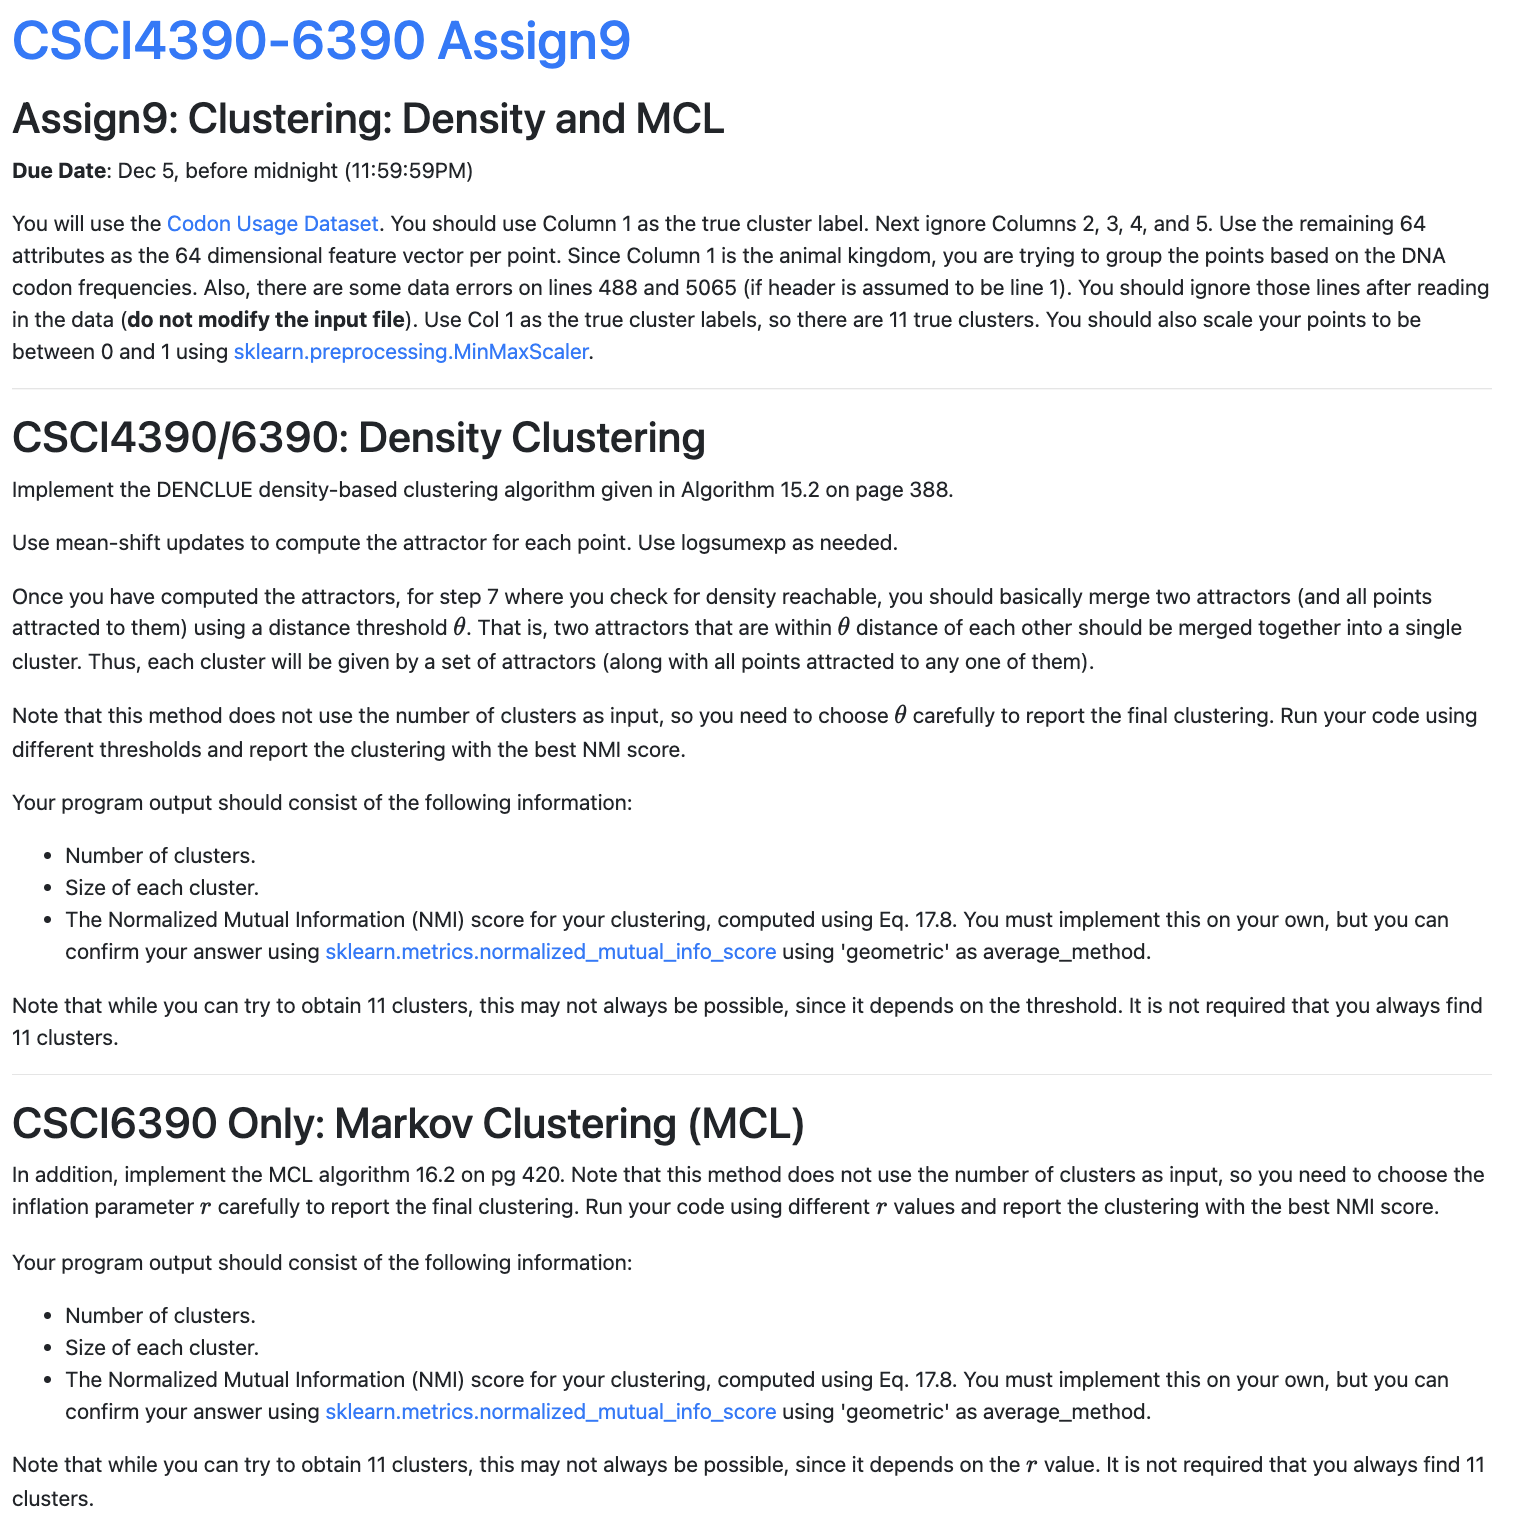

In [234]:
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.model_selection import StratifiedShuffleSplit
import networkx as nx
import math

In [235]:
invalid = [1,2,3,4]
cols = [i for i in range(69) if i not in invalid]
df = pd.read_csv("codon_usage.csv", usecols=cols)
#print(df.describe())
#print(df.columns)
D = df.to_numpy()
print(D.shape)
D = np.delete(D, 486, 0)
D = np.delete(D, 5062, 0)
print(D.shape)

(13028, 65)
(13026, 65)


/var/folders/gb/hwvzzncj2f9fs4sfs8f7q2vh0000gn/T/ipykernel_3362/2238818590.py:3: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("codon_usage.csv", usecols=cols)


In [236]:
Y = D[:,0]
X = D[:,1:]


In [237]:
d = dict(zip(list(pd.unique(Y)), range(0,11)))
d
df1 = pd.DataFrame(Y)
df1[0].map(d, na_action='ignore')

0         0
1         0
2         0
3         0
4         0
         ..
13021    10
13022    10
13023    10
13024    10
13025    10
Name: 0, Length: 13026, dtype: int64

In [238]:
Xi = []
n,d = X.shape
for i in range(n):
    row = []
    for j in range(d):
        row.append(float(X[i,j]))
    Xi.append(row)
X = np.array(Xi)
X = MinMaxScaler().fit_transform(X)

In [291]:
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.86, random_state=42)
D1 = sss.get_n_splits(X, Y)
for train_index, test_index in sss.split(X, Y):
     X_train, X_test = X[train_index], X[test_index]
     y_train, y_test = Y[train_index], Y[test_index]
X_train.shape, y_train.shape

((1823, 64), (1823,))

In [240]:
np.unique(Y,return_counts=True)

(array(['arc', 'bct', 'inv', 'mam', 'phg', 'plm', 'pln', 'pri', 'rod',
        'vrl', 'vrt'], dtype=object),
 array([ 126, 2919, 1345,  572,  220,   18, 2523,  180,  215, 2831, 2077]))

In [292]:
def computeMI(x, y):
    sum_mi = 0.0
    x_value_list = np.unique(x)
    y_value_list = np.unique(y)
    Px = np.array([ len(x[x==xval])/float(len(x)) for xval in x_value_list ]) #P(x)
    Py = np.array([ len(y[y==yval])/float(len(y)) for yval in y_value_list ]) #P(y)
    for i in range(len(x_value_list)):
        if Px[i] ==0.:
            continue
        sy = y[x == x_value_list[i]]
        if len(sy)== 0:
            continue
        pxy = np.array([len(sy[sy==yval])/float(len(y))  for yval in y_value_list]) #p(x,y)
        ict = pxy[Py>0.]/Py[Py>0.] /Px[i] # log(P(x,y)/( P(x)*P(y))
        sum_mi += sum(pxy[t>0]*np.log2( t[t>0]) ) # sum ( P(x,y)* log(P(x,y)/( P(x)*P(y)) )
    return sum_mi

# DENCLUE

In [ ]:
def get_density(x, h, X):
    n = X.shape[0]
    d = X.shape[1]
    Dx = X - x
    den = -np.sum(Dx*Dx, axis=1)/(2*h**2)
    kernel = - (np.log(n) + d*np.log(h) + d/2 * np.log(2*np.pi))
    z = scipy.special.logsumexp(den)
    R = z + kernel
    return R

def mean_shift(x, h, X):
    n, d = X.shape
    Dx = X - x
    W = np.exp(-np.sum(Dx*Dx, axis=1)/(2*h**2))
    W = np.reshape(W, (n,-1))
    x = np.sum(W*X, axis=0)/np.sum(W)
    return x

def find_attractor(x, h, X, eps=1e-3, maxiter=100):
    t = 0
    diff = 1e20
    while t < maxiter and diff > eps:
        old_x = x.copy()
        x = mean_shift(x, h, X)
        diff = np.linalg.norm(x-old_x)
        t = t+1
    return x

In [274]:
def _find_peak(x_t, X, W=None, h=0.5, eps=1e-7):

    error = 99
    prob = 0
    x_l1 = np.copy(x_t)
    
    while True:
        x_l0 = np.copy(x_l1)
        x_l1, density = _step(x_l0, X, W=W, h=h)
        error = density - prob
        prob = density
        if error < eps:
            break
    return [x_l1, prob]

def _step(x_l0, X, W=None, h=0.1):
    n = X.shape[0]
    d = X.shape[1]
    superweight = 0
    x_l1 = np.zeros((1,d))
    if W is None:
        W = np.ones((n,1))
    else:
        W = W
    for j in range(n):
        kernel = kernelize(x_l0, X[j], h, d)
        kernel = kernel/(h**d)
        superweight = superweight + kernel
        x_l1 = x_l1 + (kernel * X[j])
    x_l1 = x_l1/superweight
    density = (superweight /(X.shape[0])) * np.linalg.norm(X[j]-x_l0)
    return [x_l1, density]
    
def kernelize(x, y, h, degree):
    kernel = np.exp(-(np.linalg.norm(x-y)/h)**2/2)/((2*np.pi)**(degree/2))
    return kernel

In [290]:
class DENCLUE():
    
    def __init__(self, min_density,zeta, h=None, eps=1e-5):        
        self.h = h        
        self.eps = eps
        self.min_density = min_density
        self.zeta = zeta
        
    def fit(self, X, y, sample_weight=None):
       
        self.n_samples = X.shape[0]
        self.n_features = X.shape[1]
        density_attractors = np.zeros((self.n_samples,self.n_features))
        density = np.zeros((self.n_samples,1))
        
        sample_weight = np.ones((self.n_samples,1))
        
        atr = []
        dnsty = []
        clusts = []
        for i in range(self.n_samples):
            density_attractors[i], density[i] = _find_peak(X[i], X, W=sample_weight, h=self.h, eps=self.eps)
            if density[i] >= self.min_density:
                atr.append(density_attractors[i])
                dnsty.append(density[i])
                ci = []
                for j in range(self.n_samples):
                    if np.linalg.norm(density_attractors[i]- X[j])<=self.min_density:
                        ci.append(j)
                clusts.append(ci)
        fnl_atr =[]
        fnl_clust= []
        fnl_density = []
        for i in range(len(atr)):
            count = 0
            ind_list = []
            for j in range(len(atr)-i):
                if i != j:
                    #print(np.linalg.norm(atr[i]-atr[j]))
                    if np.linalg.norm(atr[i]-atr[j])<=self.zeta:
                        count+=1
                        ind_list = list(set(ind_list + clusts[i]))
            fnl_atr.append(atr[i])
            fnl_density.append(dnsty[i])
            fnl_clust.append(ind_list)
        self.final_atr = np.array(fnl_atr)
        self.final_clust = np.array(fnl_clust)
        self.final_density = np.array(fnl_density)
        print(len(atr),density_attractors,'----------------',len(density))
        return self

In [293]:
denclue = DENCLUE( h=0.4, eps=1e-10, min_density=1e-7, zeta =0.2)
denclue.fit( X_train, y_train)

1822 [[0.11353703 0.21641825 0.11953572 ... 0.031359   0.02327668 0.01740893]
 [0.11357373 0.21622788 0.11959229 ... 0.03135774 0.02326973 0.01729246]
 [0.10426156 0.22699413 0.10101502 ... 0.02985858 0.02355887 0.01644192]
 ...
 [0.10989921 0.22101776 0.1120691  ... 0.03073845 0.02340944 0.01727581]
 [0.1131541  0.21672369 0.11865703 ... 0.03126312 0.02329706 0.01720014]
 [0.13595307 0.19734283 0.15043063 ... 0.03223226 0.0211831  0.01817823]] ---------------- 1823


In [294]:

print(len(denclue.final_atr),(denclue.final_clust))

1822 []


# Markov clustering

In [288]:
def markov(A,r = 3,eps=1e-6):
    #new_A = A.copy()
    for i in range(A.shape[0]):
        A[i][i] = 1
    tran_mat = np.zeros(A.shape)
    for i in range(A.shape[0]):
        tran_mat[i][i] = 1/(np.sum(A[i][:]))
    #print(tran_mat)
    M = np.dot(tran_mat,A)
    #print(M)
    diff = 1
    t = 0
    while diff>eps:
        t+=1
        Mt = M*M
        for entry in np.nditer(Mt, op_flags=['readwrite']):
            entry[...] = math.pow(entry, r)
        normalize(Mt, norm="l1", axis=0)
        diff = np.linalg.norm(Mt-M)
        M = Mt
    M_final = Mt
    return M_final

In [206]:
spread = 5
A = np.exp(-(np.dot(X_train.T,X_train)/ (2*spread)))
matrix = markov(A,r=3)

In [267]:
from scipy.sparse import  csc_matrix
def get_clusters(matrix):

    matrix = csc_matrix(matrix)
    attractors = matrix.diagonal().nonzero()[0]
    clusters = set()
    for attractor in attractors:
        cluster = tuple(matrix.getrow(attractor).nonzero()[1].tolist())
        clusters.add(cluster)

    return sorted(list(clusters))

In [268]:
from scipy.sparse import  csc_matrix
get_clusters(matrix)

[(0, 19, 32, 34, 54, 61, 62),
 (1, 33, 34, 61, 62),
 (2, 19, 32, 34, 46, 54, 61, 62),
 (3, 34, 61, 62, 63),
 (4, 19, 33, 34, 61, 62),
 (5, 33, 34, 45, 61, 62),
 (6, 19, 32, 33, 34, 38, 45, 54, 61, 62),
 (6, 19, 33, 34, 41, 45, 61, 62, 63),
 (6, 23, 33, 34, 45, 61, 62, 63),
 (6, 32, 33, 34, 45, 61, 62, 63),
 (6, 33, 34, 38, 41, 45, 61, 62, 63),
 (6, 33, 34, 41, 45, 52, 61, 62, 63),
 (6, 33, 34, 41, 45, 54, 61, 62, 63),
 (6, 33, 34, 42, 61, 62, 63),
 (6, 33, 34, 51, 61, 62, 63),
 (6, 33, 34, 60, 61, 62, 63),
 (6, 34, 50, 61, 62, 63),
 (6, 34, 56, 61, 62, 63),
 (7, 33, 34, 41, 45, 61, 62, 63),
 (8, 19, 34, 61, 62),
 (9, 33, 34, 61, 62),
 (10, 19, 32, 33, 34, 54, 61, 62),
 (11, 34, 61, 62, 63),
 (12, 19, 34, 61, 62, 63),
 (13, 33, 34, 41, 45, 61, 62, 63),
 (14, 19, 34, 61, 62),
 (15, 33, 34, 61, 62, 63),
 (16, 34, 61, 62, 63),
 (17, 33, 34, 45, 61, 62),
 (18, 19, 32, 33, 34, 45, 61, 62),
 (19, 20, 33, 34, 61, 62, 63),
 (19, 22, 32, 33, 34, 45, 54, 61, 62),
 (19, 27, 32, 33, 34, 45, 61, 62,